# Explore the stream at Embudo NM

In [27]:
%matplotlib inline

import gzip
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import spacepy.toolbox as tb
import spacepy.plot as spp
import pandas as pd



In [2]:
dfile = 'Embudo_stream_ts_raw.txt.gz'

In [3]:
dat = pd.read_csv(dfile, skiprows=30, delimiter='\t', header=None, names=('agency', 'site','datetime', 'TZ', 
                                                                          'discharge', 'd_a', 'gague', 'g_a'))
print(dat[0:20])


   agency     site          datetime   TZ  discharge d_a  gague g_a
0    USGS  8279500  2007-10-01 00:15  MDT      536.0   A   3.25   A
1    USGS  8279500  2007-10-01 00:30  MDT      536.0   A   3.25   A
2    USGS  8279500  2007-10-01 00:45  MDT      536.0   A   3.25   A
3    USGS  8279500  2007-10-01 01:00  MDT      531.0   A   3.24   A
4    USGS  8279500  2007-10-01 01:15  MDT      531.0   A   3.24   A
5    USGS  8279500  2007-10-01 01:30  MDT      531.0   A   3.24   A
6    USGS  8279500  2007-10-01 01:45  MDT      531.0   A   3.24   A
7    USGS  8279500  2007-10-01 02:00  MDT      531.0   A   3.24   A
8    USGS  8279500  2007-10-01 02:15  MDT      526.0   A   3.23   A
9    USGS  8279500  2007-10-01 02:30  MDT      526.0   A   3.23   A
10   USGS  8279500  2007-10-01 02:45  MDT      526.0   A   3.23   A
11   USGS  8279500  2007-10-01 03:00  MDT      526.0   A   3.23   A
12   USGS  8279500  2007-10-01 03:15  MDT      522.0   A   3.22   A
13   USGS  8279500  2007-10-01 03:30  MDT      5

In [4]:
index = pd.DatetimeIndex(dat['datetime'] + " " + dat['TZ'], infer_datetime_format=True)
dat.set_index(index, inplace=True)
dat.drop('datetime', axis=1, inplace=True)
dat.drop('TZ', axis=1, inplace=True)
print(dat[:10])

                    agency     site  discharge d_a  gague g_a
2007-10-01 06:15:00   USGS  8279500      536.0   A   3.25   A
2007-10-01 06:30:00   USGS  8279500      536.0   A   3.25   A
2007-10-01 06:45:00   USGS  8279500      536.0   A   3.25   A
2007-10-01 07:00:00   USGS  8279500      531.0   A   3.24   A
2007-10-01 07:15:00   USGS  8279500      531.0   A   3.24   A
2007-10-01 07:30:00   USGS  8279500      531.0   A   3.24   A
2007-10-01 07:45:00   USGS  8279500      531.0   A   3.24   A
2007-10-01 08:00:00   USGS  8279500      531.0   A   3.24   A
2007-10-01 08:15:00   USGS  8279500      526.0   A   3.23   A
2007-10-01 08:30:00   USGS  8279500      526.0   A   3.23   A


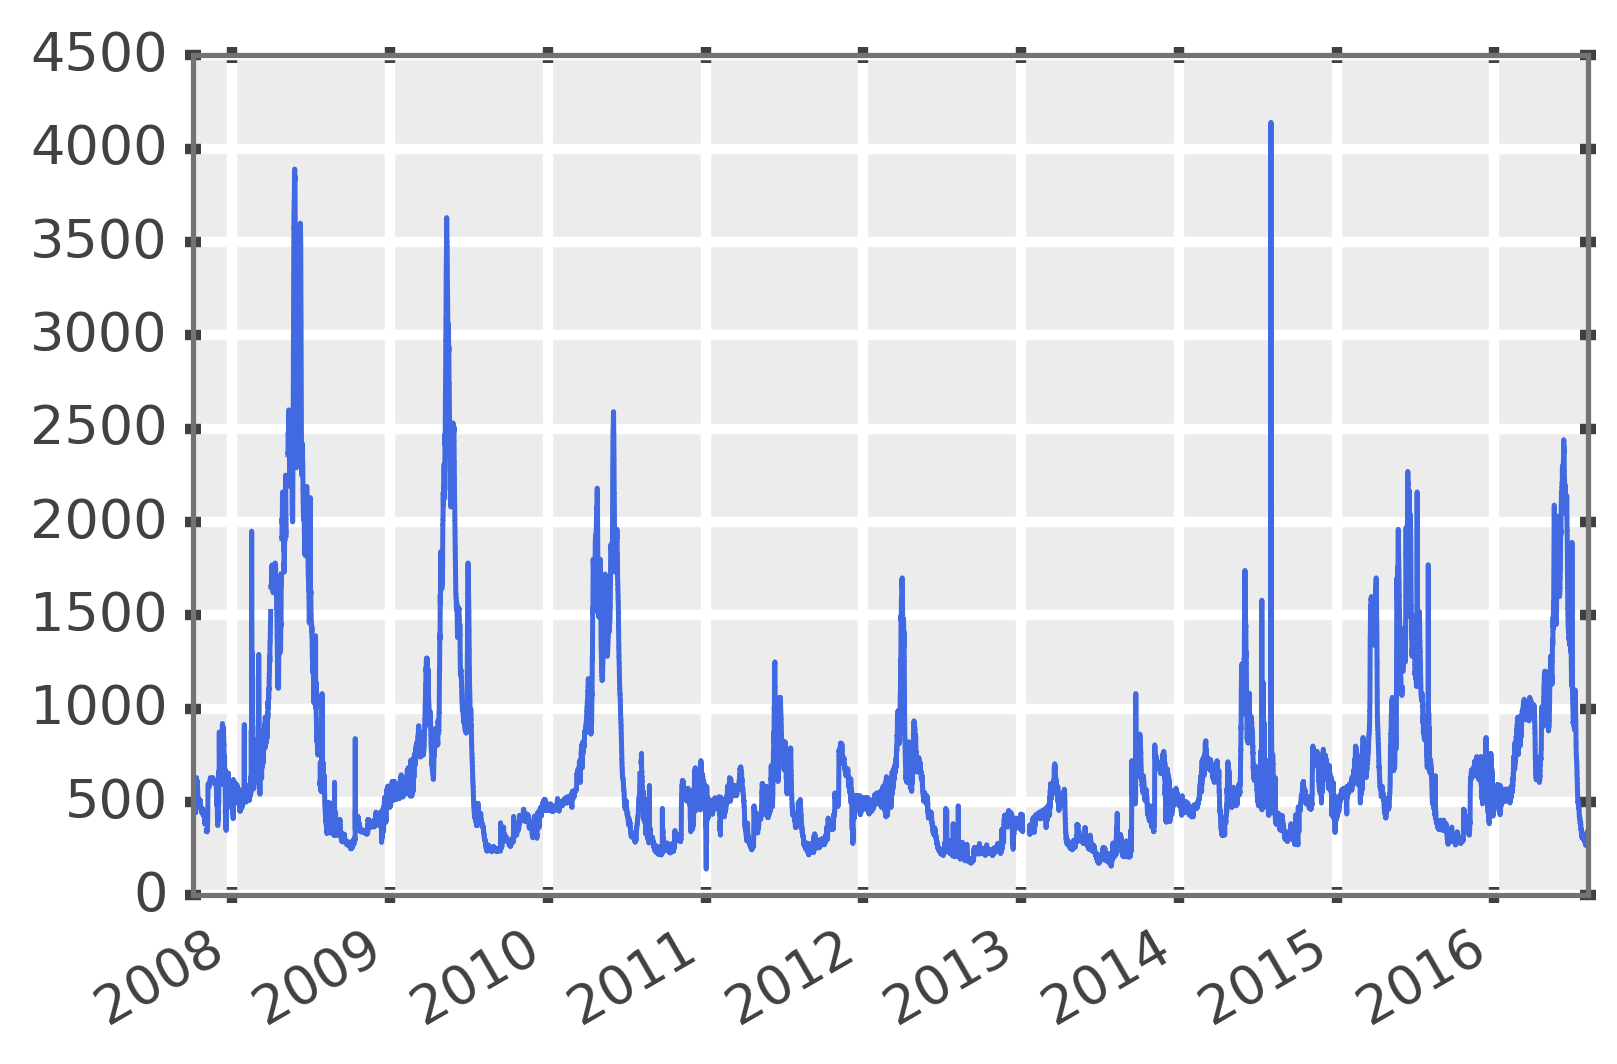

In [5]:
dat['discharge'].plot()

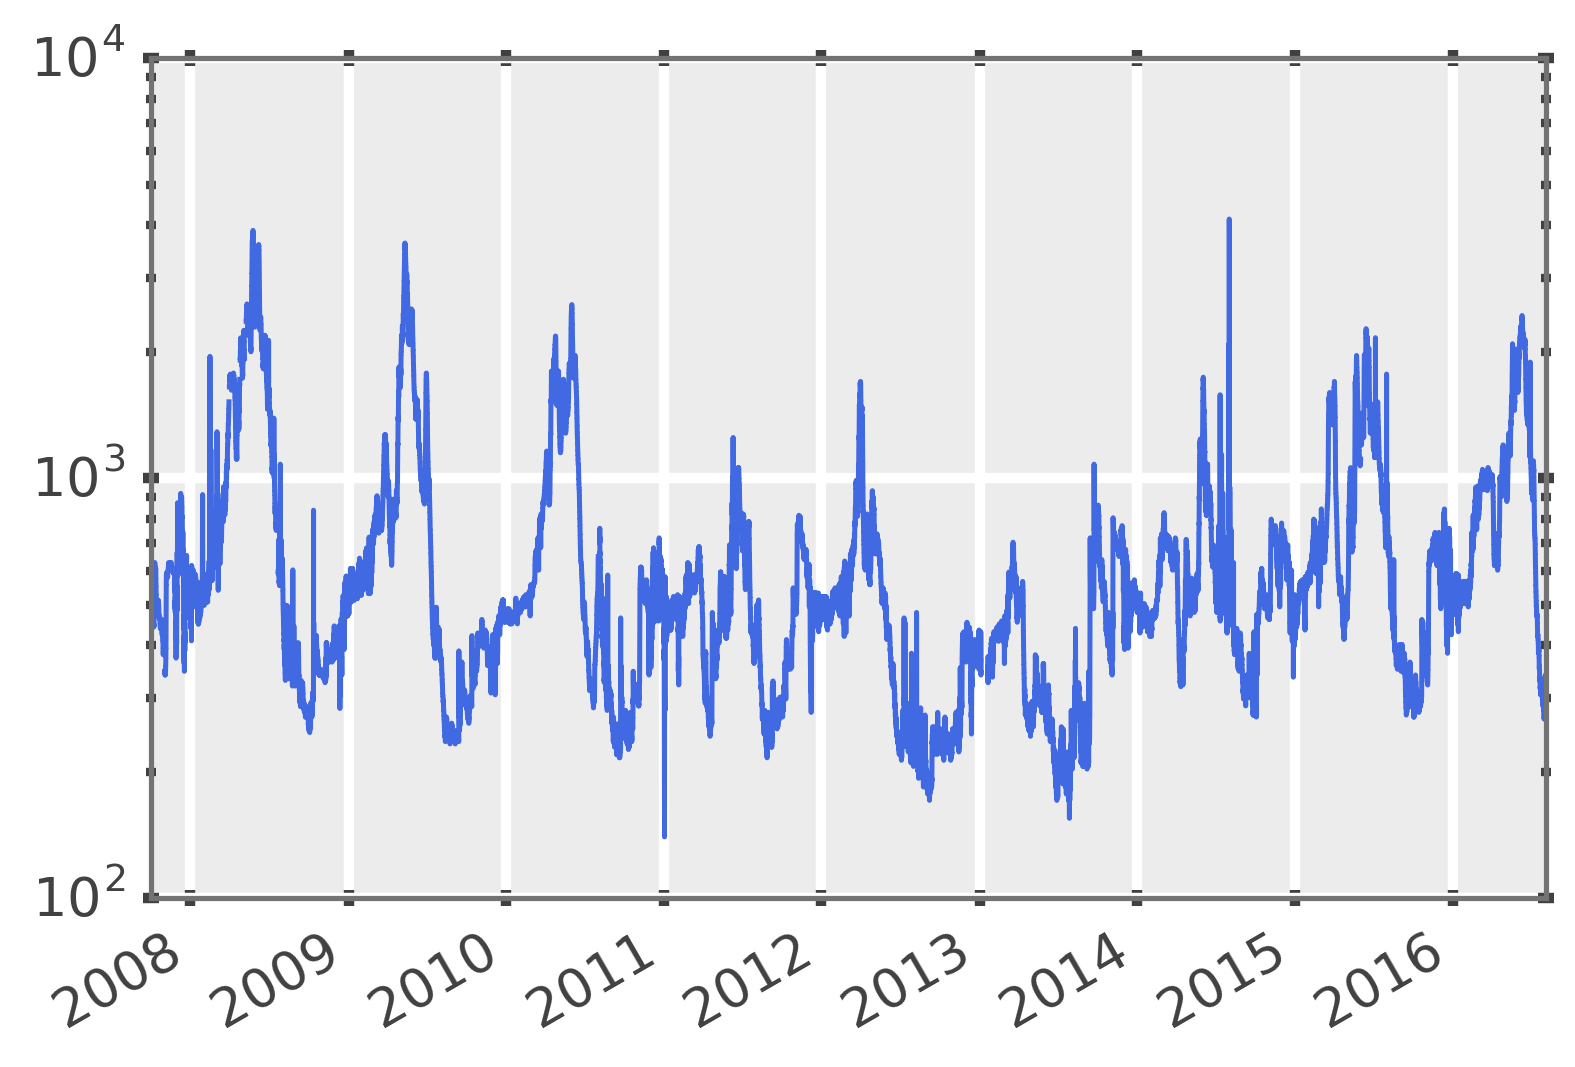

In [6]:
dat['discharge'].plot()
plt.yscale('log')

/Users/blarsen/miniconda3/envs/python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).max()
  if __name__ == '__main__':


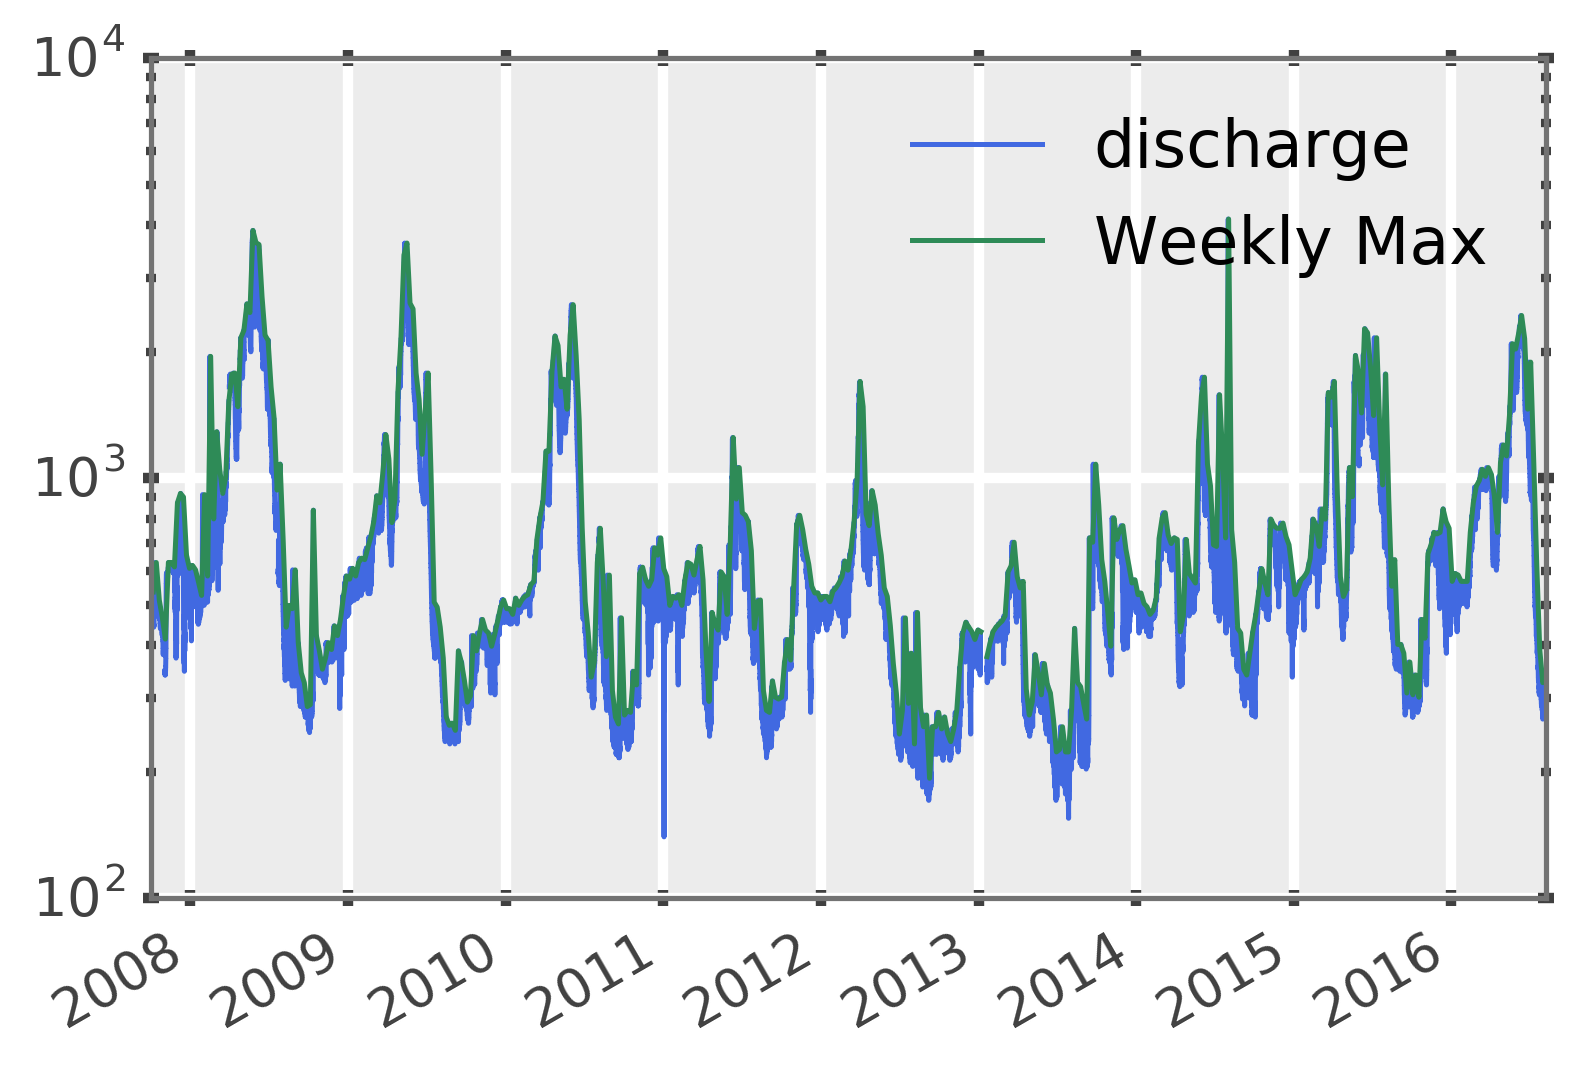

In [14]:
daily_max = dat['discharge'].resample('1w',how='max')
dat['discharge'].plot()
daily_max.plot(label='Weekly Max')
plt.yscale('log')
plt.legend()


In [21]:
v

array([  536.,   630.,   512.,   466.,   414.,   630.,   630.,   615.,
         874.,   920.,   902.,   655.,   610.,   620.,   605.,   565.,
         526.,   914.,   585.,  1950.,   800.,  1290.,  1050.,   920.,
        1010.,  1520.,  1770.,  1780.,  1480.,  2160.,  2250.,  2600.,
        2480.,  3890.,  3640.,  3600.,  2710.,  2190.,  2130.,  1650.,
        1390.,   937.,  1080.,   713.,   442.,   498.,   489.,   605.,
         406.,   344.,   326.,   286.,   289.,   839.,   422.,   388.,
         351.,   373.,   406.,   391.,   445.,   422.,   462.,   526.,
         585.,   575.,   610.,   585.,   630.,   645.,   640.,   682.,
         724.,   789.,   908.,   874.,  1030.,  1270.,  1110.,   784.,
         891.,  1610.,  2160.,  3400.,  3630.,  2610.,  2530.,  1780.,
        1540.,  1140.,  1440.,  1780.,   997.,   507.,   493.,   442.,
         373.,   270.,   258.,   261.,   251.,   388.,   365.,   330.,
         293.,   303.,   422.,   388.,   428.,   461.,   435.,   428.,
      

## Now we fit this to a Generalized extreme value using a Bayesian technique


In [28]:
import pymc


In [60]:
# Define the priors for the location (xi), scale (alpha) and shape (kappa)
# parameters.

xi = pymc.Uniform('xi', rseed=True, lower=daily_max.min(), upper=daily_max.max(), doc='Location parameter')

@pymc.deterministic(plot=True)
def alpha(xi=xi):
    """Scale parameter"""
    return 1./xi

kappa = pymc.Beta('kappa', rseed=True, alpha=5., beta=6., doc='Shape parameter')

# @pymc.data
# @pymc.stochastic_from_data('D', lower=0, upper=1e6, data=daily_max.as_matrix())
def D(value=daily_max.as_matrix(), location=xi, scale=alpha, shape=kappa, lower=0, upper=1e6):
   return pymc.gev_like(value, shape, location, scale)


In [61]:
@pymc.stochastic_from_data

SyntaxError: unexpected EOF while parsing (<ipython-input-61-80832237b387>, line 1)

In [62]:
type(daily_max.min())

numpy.float64

In [63]:
model = pymc.MCMC((xi, alpha, kappa, D))

In [64]:
model.sample(iter=50000, verbose=True, burn_till_tuned=True)

burn_til_tuned is True. tune_throughout is set to False
	Tuning at iteration 1000
	Tuning at iteration 2000
	Tuning at iteration 3000
	Tuning at iteration 4000
	Tuning at iteration 5000

Finished tuning

Burn-in interval complete

Sampling finished normally.


{'alpha': {'95% HPD interval': array([ 0.00024155,  0.00258287]),
           'mc error': 3.4447776292872633e-06,
           'mean': 0.00077877887942860138,
           'n': 50000,
           'quantiles': {2.5: 0.00024744273920413227,
                         25: 0.00031710782445833744,
                         50: 0.00046264615128589244,
                         75: 0.0008529418804122872,
                         97.5: 0.003467644524505232},
           'standard deviation': 0.00080597882841497393},
 'kappa': {'95% HPD interval': array([ 0.176397  ,  0.72558016]),
           'mc error': 0.00063916707235935608,
           'mean': 0.45357854047646318,
           'n': 50000,
           'quantiles': {2.5: 0.18791975139324998,
                         25: 0.34967872591008453,
                         50: 0.45046463929434316,
                         75: 0.55493744198456052,
                         97.5: 0.73813941471060684},
           'standard deviation': 0.1437693945621332},
 'xi': {'95% 

/Users/blarsen/miniconda3/envs/python3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:225: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return reshape(newshape, order=order)


Plotting alpha
Plotting xi


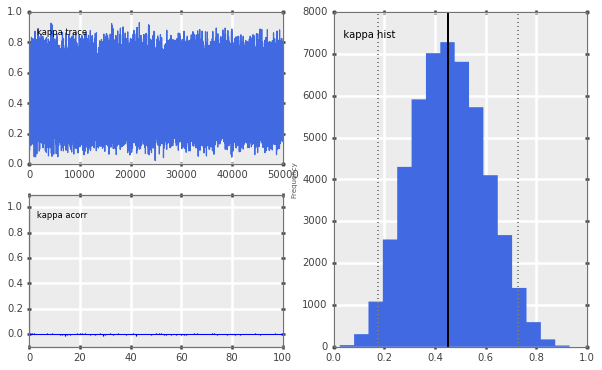

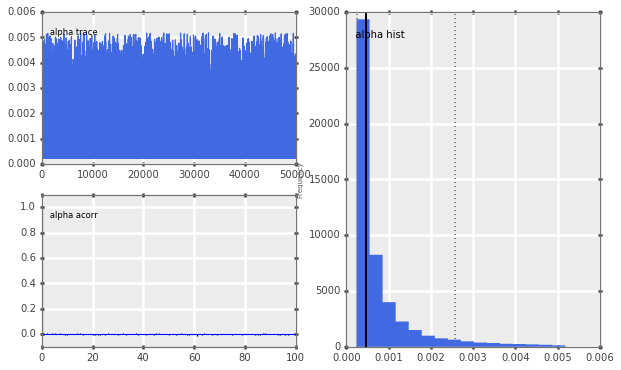

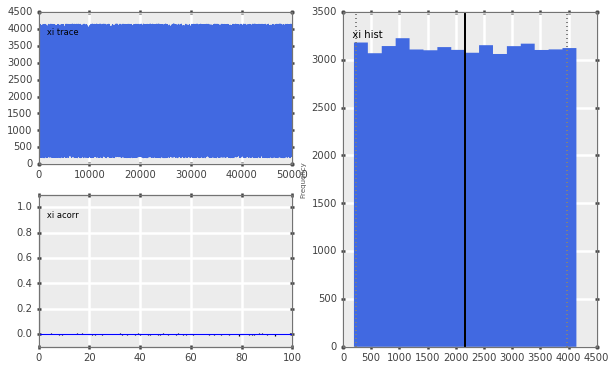

In [65]:
pprint(model.stats())
pymc.Matplot.plot(model)

In [69]:
model.variables

{<pymc.distributions.new_dist_class.<locals>.new_class 'xi' at 0x122363ef0>,
 <pymc.PyMCObjects.Deterministic 'alpha' at 0x122363e48>,
 <pymc.distributions.new_dist_class.<locals>.new_class 'kappa' at 0x122363f28>}